# 1. Load DataSet

In [1]:
!unzip -q datas.zip -d /content/mydata

# 2. Install Required Libraries

In [2]:
import json
import cv2
import numpy as np
from skimage.draw import polygon
import os

# 3. Preprocess the Data

In [3]:
annotation_file = '/content/mydata/datas/annotations_all.json'

In [4]:
# Load the JSON file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Create a directory to save masks
os.makedirs('masks', exist_ok=True)

In [6]:
# Process each image in the annotations
for image_key, image_info in annotations.items():
    # Extract filename
    filename = image_info['filename']
    regions = image_info['regions']

    # Load the image to get its dimensions
    image_path = os.path.join('/content/mydata/datas/all', filename)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        continue

    height, width, _ = image.shape

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Draw polygons on the mask
    for region in regions:
        if region['shape_attributes']['name'] == 'polygon':
            x_coords = region['shape_attributes']['all_points_x']
            y_coords = region['shape_attributes']['all_points_y']

            # Clip coordinates to ensure they are within image dimensions
            x_coords = np.clip(x_coords, 0, width - 1)
            y_coords = np.clip(y_coords, 0, height - 1)

            # Draw the polygon on the mask
            rr, cc = polygon(y_coords, x_coords)
            mask[rr, cc] = 1  # Set the mask to 1 for the tumor region

    # Save the mask
    mask_filename = os.path.join('masks', filename)
    cv2.imwrite(mask_filename, mask * 255)  # Multiply by 255 to save as an image
    print(f"Mask saved for {filename} at {mask_filename}")

Mask saved for y0.jpg at masks/y0.jpg
Mask saved for y1.jpg at masks/y1.jpg
Mask saved for y2.jpg at masks/y2.jpg
Mask saved for y3.jpg at masks/y3.jpg
Mask saved for y4.jpg at masks/y4.jpg
Mask saved for y5.jpg at masks/y5.jpg
Mask saved for y6.jpg at masks/y6.jpg
Mask saved for y7.jpg at masks/y7.jpg
Mask saved for y8.jpg at masks/y8.jpg
Mask saved for y9.jpg at masks/y9.jpg
Mask saved for y10.jpg at masks/y10.jpg
Mask saved for y11.jpg at masks/y11.jpg
Mask saved for y12.jpg at masks/y12.jpg
Mask saved for y13.jpg at masks/y13.jpg
Mask saved for y14.jpg at masks/y14.jpg
Mask saved for y15.jpg at masks/y15.jpg
Mask saved for y16.jpg at masks/y16.jpg
Mask saved for y17.jpg at masks/y17.jpg
Mask saved for y18.jpg at masks/y18.jpg
Mask saved for y19.jpg at masks/y19.jpg
Mask saved for y20.jpg at masks/y20.jpg
Mask saved for y21.jpg at masks/y21.jpg
Mask saved for y22.jpg at masks/y22.jpg
Mask saved for y23.jpg at masks/y23.jpg
Mask saved for y24.jpg at masks/y24.jpg
Mask saved for y25.j

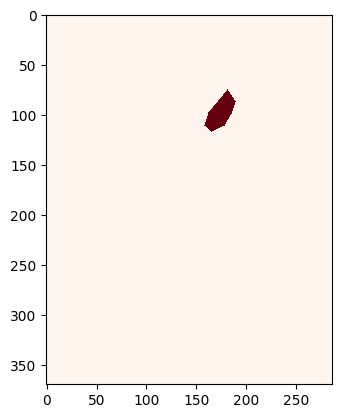

In [9]:
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='Reds')
plt.show()

# 4. Prepare the DataSet

In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define image size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# List of supported image extensions
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

def load_data(image_dir, mask_dir):
    images = []
    masks = []

    # Iterate over files in the image directory
    for image_name in os.listdir(image_dir):
        # Skip non-image files
        if not any(image_name.lower().endswith(ext) for ext in IMAGE_EXTENSIONS):
            print(f"Skipping non-image file: {image_name}")
            continue

        # Construct full paths for image and mask
        image_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name)

        # Load image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Error: Unable to load image at {image_path}")
            continue

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error: Unable to load mask at {mask_path}")
            continue

        # Resize image and mask
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        # Normalize image and mask
        image = image / 255.0
        mask = mask / 255.0

        # Expand mask dimensions
        mask = np.expand_dims(mask, axis=-1)

        # Append to lists
        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
image_dir = '/content/mydata/datas/all'
mask_dir = '/content/masks'
images, masks = load_data(image_dir, mask_dir)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# 5. Build a CNN Segmentation Model

## U-Net Model for Segmentation

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Upsample
    up3 = UpSampling2D(size=(2, 2))(conv2)
    up3 = concatenate([up3, conv1], axis=-1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs, outputs)
    return model

# Build the model
model = unet(input_size=(IMG_WIDTH, IMG_HEIGHT, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 256, 256, 128)  │              0 │ conv2d_3[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 192)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 1)    │             65 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 407,809 (1.56 MB)

 Trainable params: 407,809 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - accuracy: 0.8856 - loss: 0.3271 - val_accuracy: 0.9452 - val_loss: 0.1371
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9455 - loss: 0.1399 - val_accuracy: 0.9452 - val_loss: 0.1469
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9471 - loss: 0.1358 - val_accuracy: 0.9452 - val_loss: 0.1394
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.9462 - loss: 0.1337 - val_accuracy: 0.9481 - val_loss: 0.1343
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.9513 - loss: 0.1250 - val_accuracy: 0.9497 - val_loss: 0.1300
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9520 - loss: 0.1234 - val_accuracy: 0.9515 - val_loss: 0.1305
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.9506 - loss: 0.1264 - val_accuracy: 0.9491 - val_loss: 0.1314
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9486 - loss: 0.1300 - val_accu

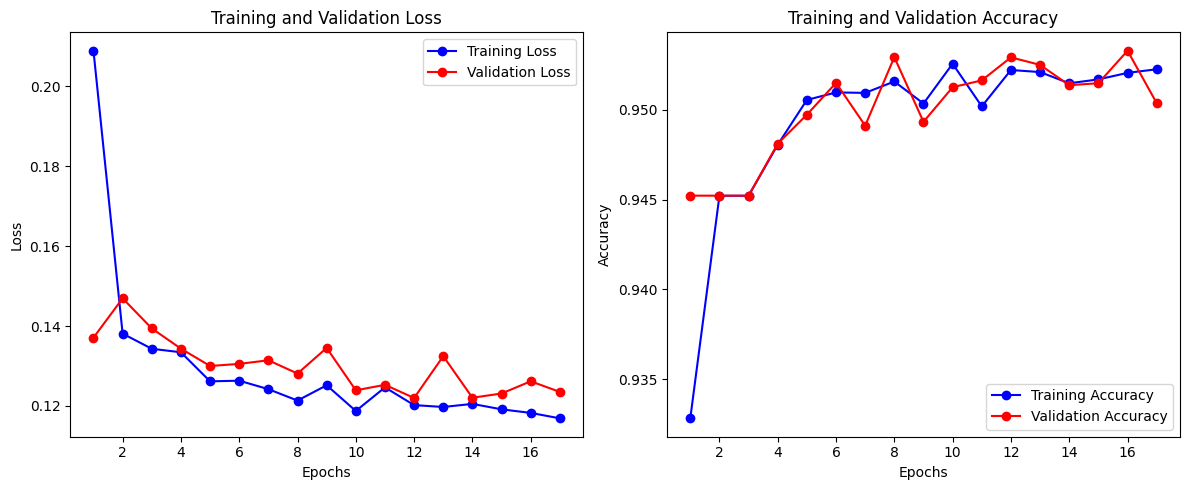

In [13]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    """
    Plots the training and validation loss and accuracy for a given model history.

    Args:
        history: The history object returned by the `fit` method.
    """
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the model history
plot_model_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


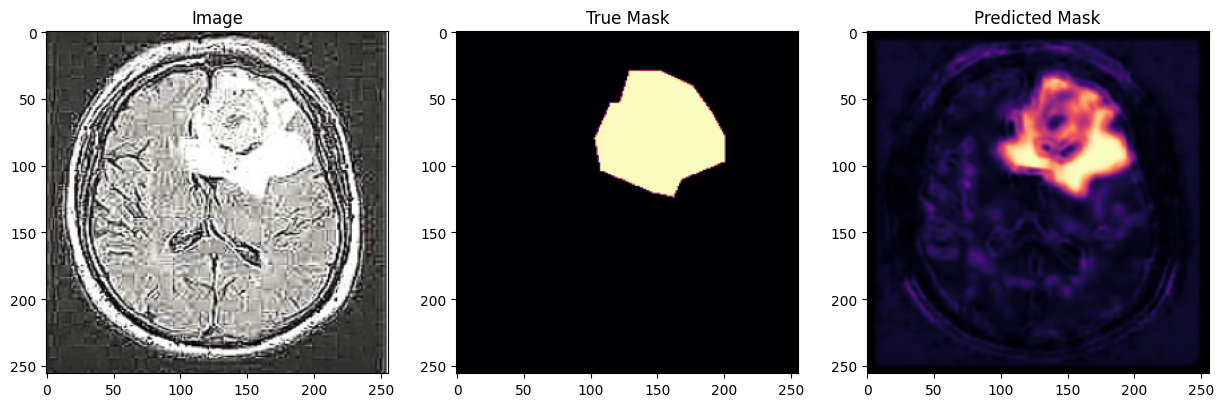

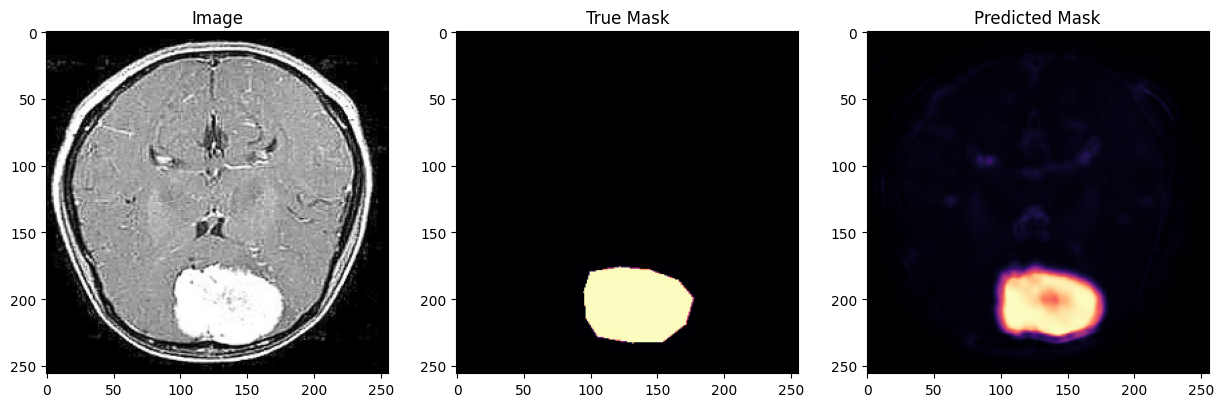

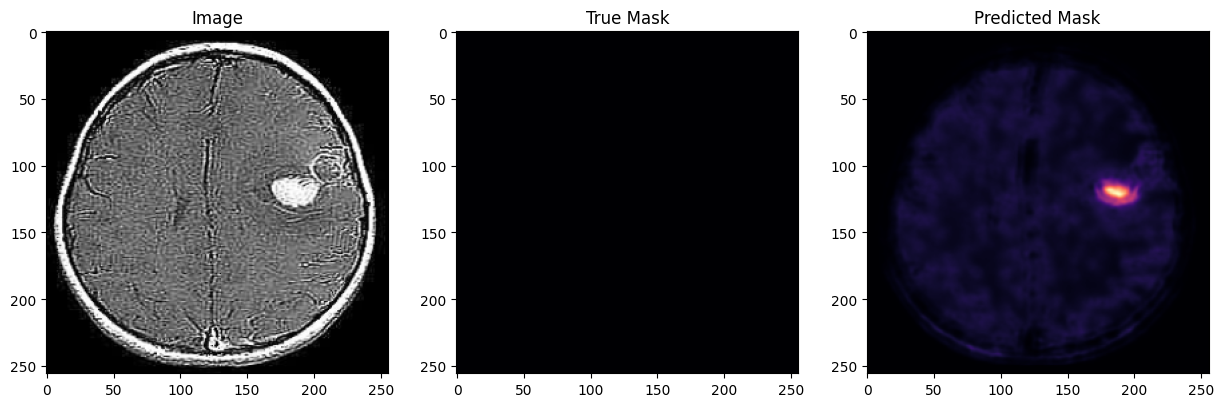

In [16]:
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = model.predict(X_val)

# Display results
def display_results(image, mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask, cmap='magma')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='magma')

    plt.show()

# Display first 3 results
for i in range(3):
    display_results(X_val[i], y_val[i], y_pred[i])

In [17]:
# Save the model
model.save('uNet_tumor_segmentation_model.h5')

## Buid the DeepLabV3+

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# ASPP Module (Atrous Spatial Pyramid Pooling)
def ASPP(x, filters=256):
    shape = tf.keras.backend.int_shape(x)

    y1 = Conv2D(filters, (1, 1), padding="same", use_bias=False)(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, (3, 3), dilation_rate=6, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, (3, 3), dilation_rate=12, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, (3, 3), dilation_rate=18, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y5 = Conv2D(filters, (1, 1), padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(filters, (1, 1), padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# DeepLabV3+ Model
def DeepLabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")

    # Extract feature maps
    high_level_features = base_model.get_layer("block_13_expand_relu").output  # (32x32)
    low_level_features = base_model.get_layer("block_2_expand_relu").output  # (128x128)

    # Apply ASPP on high-level features
    x = ASPP(high_level_features)

    # Upsample to match low-level feature size
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Reduce low-level feature channels
    low_level_features = Conv2D(48, (1, 1), padding="same", use_bias=False)(low_level_features)
    low_level_features = BatchNormalization()(low_level_features)
    low_level_features = Activation("relu")(low_level_features)

    # Concatenate low and high-level features
    x = Concatenate()([x, low_level_features])

    # Final decoder layers
    x = Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Upsample to original image size
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Final output layer
    x = Conv2D(num_classes, (1, 1), padding="same")(x)
    x = Activation("sigmoid" if num_classes == 1 else "softmax")(x)

    return Model(inputs=base_model.input, outputs=x)

# Build the model
INPUT_SHAPE = (256, 256, 3)  # Adjust input shape if needed
NUM_CLASSES = 1

model = DeepLabV3Plus(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


<ipython-input-18-79554b60864a>:40: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 6,525,953 (24.89 MB)

 Trainable params: 6,504,481 (24.81 MB)

 Non-trainable params: 21,472 (83.88 KB)

Train the Model

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 100s 538ms/step - accuracy: 0.9119 - loss: 0.2179 - val_accuracy: 0.8876 - val_loss: 0.2434
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.9745 - loss: 0.0431 - val_accuracy: 0.9400 - val_loss: 0.1267
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.9780 - loss: 0.0340 - val_accuracy: 0.9601 - val_loss: 0.0770
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.9792 - loss: 0.0288 - val_accuracy: 0.9704 - val_loss: 0.0599
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9801 - loss: 0.0269 - val_accuracy: 0.9342 - val_loss: 0.1261
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step - accuracy: 0.9803 - loss: 0.0243 - val_accuracy: 0.9675 - val_loss: 0.0671
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9814 - loss: 0.0222 - val_accuracy: 0.9641 - val_loss: 0.0762
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.9825 - loss: 0.0197 - val_acc

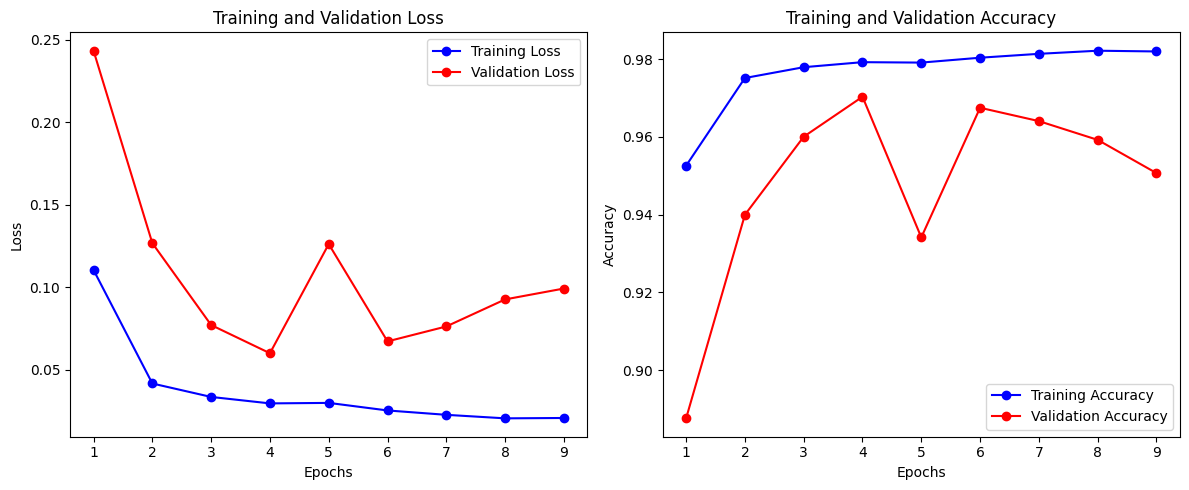

In [20]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    """
    Plots the training and validation loss and accuracy for a given model history.

    Args:
        history: The history object returned by the `fit` method.
    """
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the model history
plot_model_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step


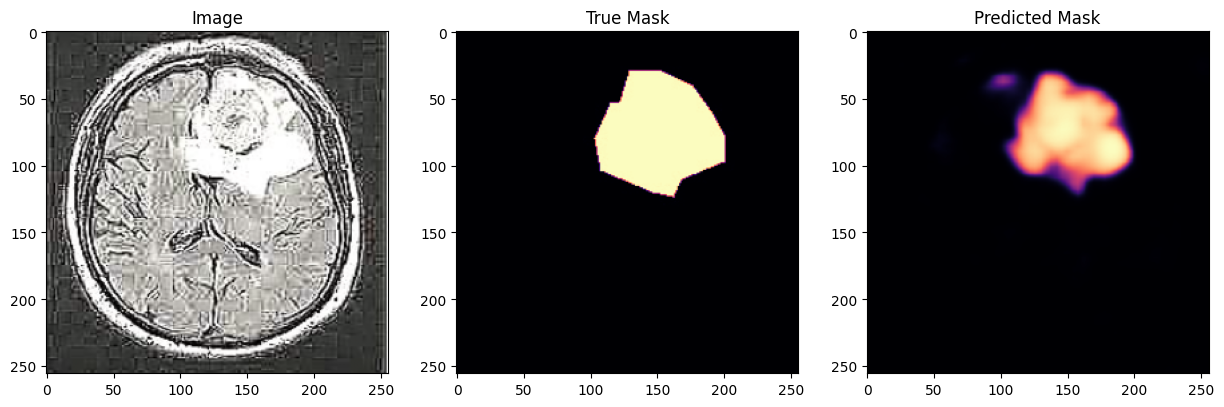

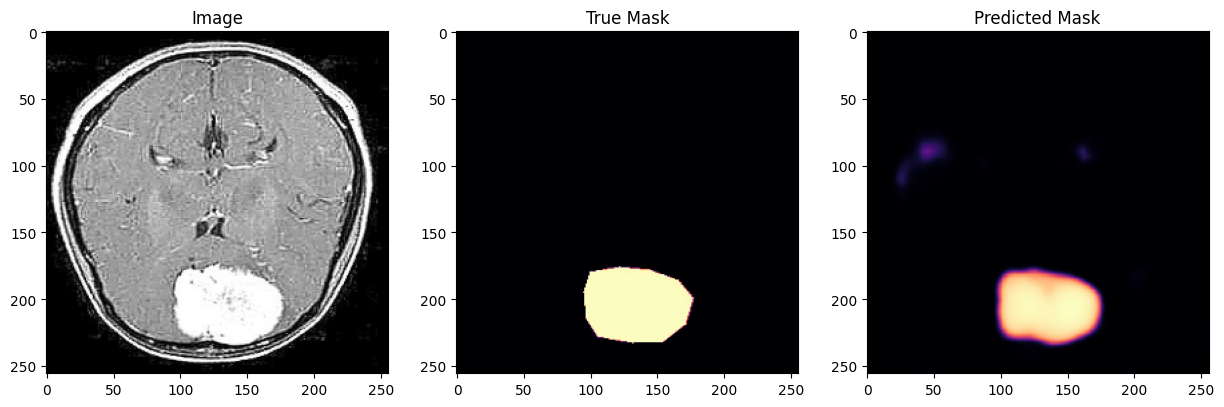

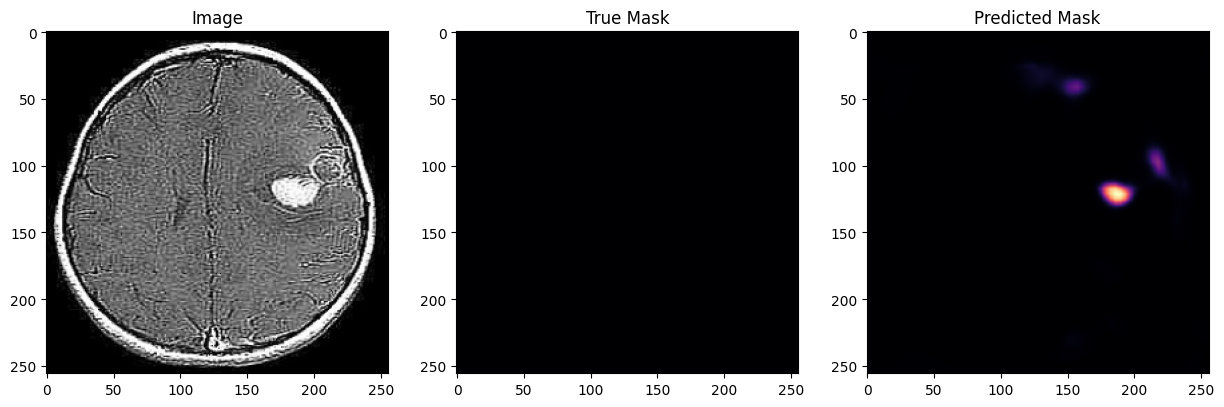

In [21]:
# Predict on validation set
y_pred = model.predict(X_val)

# Visualize predictions
def display_results(image, mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask, cmap='magma')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='magma')

    plt.show()

# Display first 3 results
for i in range(3):
    display_results(X_val[i], y_val[i], y_pred[i])

In [22]:
model.save('deeplabv3plus_tumor_segmentation.h5')

## U-Net with ResNet50 as the Backbone

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model

def resnet50_unet(input_size=(256, 256, 3)):
    # Load ResNet50 as the backbone
    backbone = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')

    # Freeze the backbone layers
    for layer in backbone.layers:
        layer.trainable = False

    # Encoder (ResNet50 as the backbone)
    layer_names = [
        'conv1_relu',          # 128x128
        'conv2_block3_out',    # 64x64
        'conv3_block4_out',    # 32x32
        'conv4_block6_out',    # 16x16
        'conv5_block3_out'     # 8x8
    ]
    encoder_outputs = [backbone.get_layer(name).output for name in layer_names]

    # Decoder
    def decoder_block(input_tensor, skip_tensor, filters):
        x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
        x = concatenate([x, skip_tensor])
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Start with the last encoder output
    x = encoder_outputs[-1]

    # Decoder blocks
    x = decoder_block(x, encoder_outputs[-2], 512)  # 16x16
    x = decoder_block(x, encoder_outputs[-3], 256)  # 32x32
    x = decoder_block(x, encoder_outputs[-4], 128)  # 64x64
    x = decoder_block(x, encoder_outputs[-5], 64)   # 128x128

    # Final upsampling to match input size
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=backbone.input, outputs=outputs)
    return model





In [24]:
# Build the model
resnet_unet_model = resnet50_unet(input_size=(IMG_WIDTH, IMG_HEIGHT, 3))
resnet_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_unet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 47,108,513 (179.70 MB)

 Trainable params: 23,516,897 (89.71 MB)

 Non-trainable params: 23,591,616 (89.99 MB)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with early stopping
history_resnet_unet = resnet_unet_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,  # Set a higher number of epochs (early stopping will handle stopping)
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 437ms/step - accuracy: 0.9212 - loss: 0.3134 - val_accuracy: 0.9432 - val_loss: 0.3759
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.9479 - loss: 0.1702 - val_accuracy: 0.9452 - val_loss: 0.4311
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9505 - loss: 0.1353 - val_accuracy: 0.9452 - val_loss: 0.3775
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.9564 - loss: 0.1134 - val_accuracy: 0.9452 - val_loss: 0.2706
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9591 - loss: 0.1027 - val_accuracy: 0.9452 - val_loss: 0.1810
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9593 - loss: 0.0937 - val_accuracy: 0.2256 - val_loss: 0.9850
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.9607 - loss: 0.0906 - val_accuracy: 0.9452 - val_loss: 0.1736
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.9593 - loss: 0.0881 - val_accu

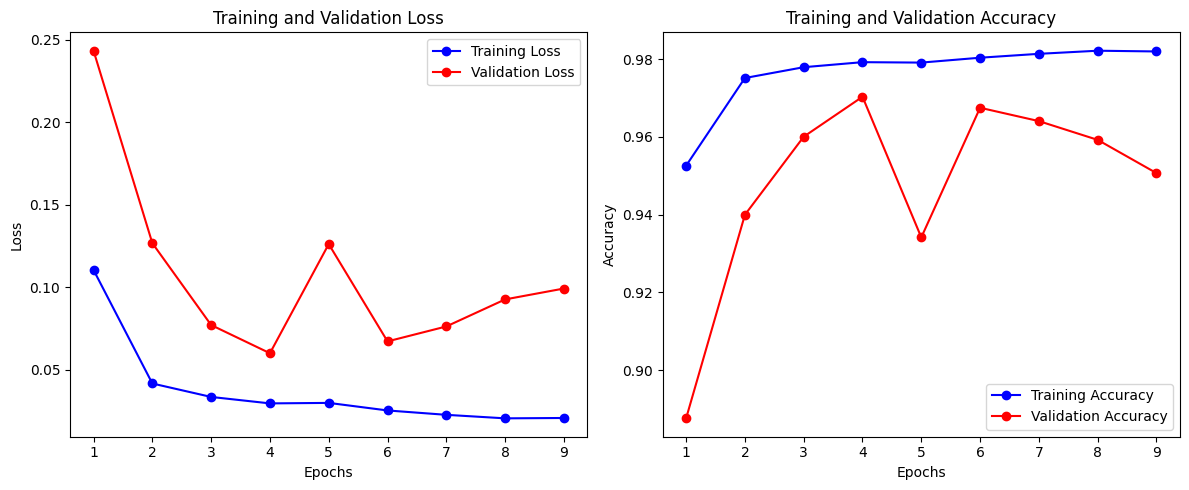

In [26]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    """
    Plots the training and validation loss and accuracy for a given model history.

    Args:
        history: The history object returned by the `fit` method.
    """
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the model history
plot_model_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


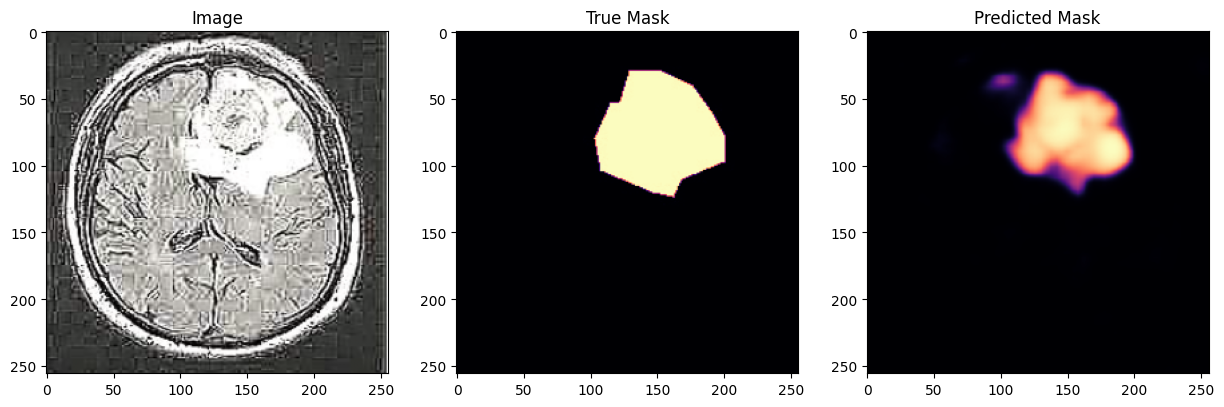

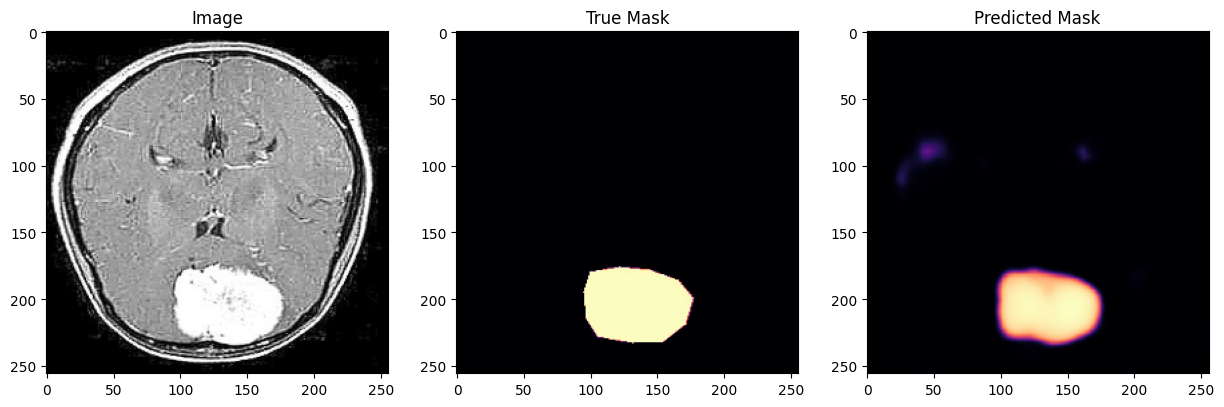

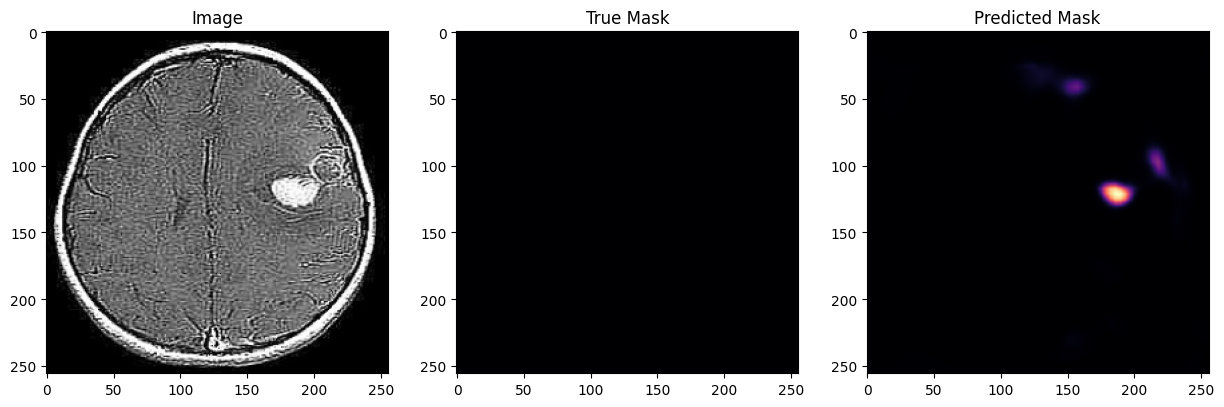

In [27]:
# Predict on validation set
y_pred = model.predict(X_val)

# Visualize predictions
def display_results(image, mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask, cmap='magma')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='magma')

    plt.show()

# Display first 5 results
for i in range(3):
    display_results(X_val[i], y_val[i], y_pred[i])

In [28]:
model.save('resnet50_unet_tumor_segmentation.h5')

# 6. Deployment

Install Gradio

In [29]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [44]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained U-Net model
model = load_model("/content/uNet_tumor_segmentation_model.h5")

def predict_tumor_mask(input_image):
    try:
        # Convert RGB to BGR (OpenCV format)
        input_image_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

        # Resize to 256x256
        resized_image = cv2.resize(input_image_bgr, (256, 256))

        # Normalize to [0, 1]
        normalized_image = resized_image / 255.0

        # Add batch dimension
        batch_image = np.expand_dims(normalized_image, axis=0)

        # Predict tumor mask
        pred_mask = model.predict(batch_image, verbose=0)[0]

        # Postprocess the mask (thresholding)
        binary_mask = (pred_mask > 0.3).astype(np.uint8) * 255
        if len(binary_mask.shape) == 3 and binary_mask.shape[2] > 1:
            binary_mask = binary_mask[:, :, 0]  # Ensure single-channel

        # Apply Magma colormap
        magma_colormap = cv2.applyColorMap(binary_mask, cv2.COLORMAP_MAGMA)

        # Stronger overlay effect
        overlay = cv2.addWeighted(magma_colormap, 0.7, resized_image, 0.3, 0)

        # Convert images to RGB for Gradio display
        original_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.cvtColor(magma_colormap, cv2.COLOR_BGR2RGB)
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        return original_image_rgb, mask_rgb, overlay_rgb

    except Exception as e:
        print(f"Error: {e}")
        return None, None, None

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# Tumor Segmentation with U-Net 🧠")
    with gr.Row():
        input_image = gr.Image(label="Upload an MRI/CT Scan")
        output_images = [
            gr.Image(label="Original Image"),
            gr.Image(label="Predicted Mask"),
            gr.Image(label="Overlay")

        ]
    predict_btn = gr.Button("Segment Tumor")
    predict_btn.click(fn=predict_tumor_mask, inputs=input_image, outputs=output_images)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://371fe38c5010048404.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
